In [2]:
import random
import numpy as np
import operator
import math
import pandas as pd
import time
import os
import dill
from sympy import *
from sympy.parsing import sympy_parser

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp
from scoop import futures
from pandas import DataFrame

from concurrent.futures import ProcessPoolExecutor
import matplotlib.pyplot as plt
import multiprocessing as mp


def plot_pred(hof):
    func = toolbox.compile(expr=hof[0])
    y_hat = []

    for i,c1,c2,c3,c4,c5,c6 in pts:
        y_hat.append(func(i,c1,c2,c3,c4,c5,c6))

        
    from matplotlib import pyplot as plt
    plt.plot(t,y1)
    plt.plot(t, y_hat)

    plt.xlabel('time')  # x-axis
    plt.ylabel('x(t)')  # y-axis
    plt.title('Data')  # title
    plt.grid()  # grid
    plt.legend(['with error','predicted','real'])
    plt.show()  # plot show

###################### Define functions############################
def safeDiv(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1
    
def sqrt(left):
    if left>=0:
        return left**0.5
    else:
        return 0
    
def expe(left):
    if left>=0:
        return np.exp(-left)
    else:
        return 0


pset = gp.PrimitiveSet("MAIN", 8)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(expe, 1)
# pset.addPrimitive(safeDiv, 2)
pset.addPrimitive(sqrt,1)
# pset.addPrimitive(operator.neg, 1)
pset.addPrimitive(math.cos, 1)
pset.addPrimitive(math.sin, 1)

pset.renameArguments(ARG0='v1')
pset.renameArguments(ARG1='v2')
pset.renameArguments(ARG2='c1')
pset.renameArguments(ARG3='c2')
pset.renameArguments(ARG4='c3')
pset.renameArguments(ARG5='c4')
pset.renameArguments(ARG6='c5')
pset.renameArguments(ARG7='c6')

###################################################################
pool = mp.Pool(30)

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=3)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)
#toolbox.register("map", futures.map)

#########################input DATA#################################

def evalSymbReg(individual, points):
    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual)

    # Evaluate the mean squared error between the expression
    sqerrors = ((func(v1,v2,c1,c2,c3,c4,c5,c6) - f[t])**2 for t,v1,v2,c1,c2,c3,c4,c5,c6 in points)

    try:
        return max(sqerrors),
    except IndexError:
        return max(sqerrors),
    
toolbox.register("map", pool.map)

g = pd.read_csv('dp_pos.csv')
x1 = g['x1']
y1 = g['y1']
x2 = g['x2']
y2 = g['y2']
t = g['t']

g = pd.read_csv('dp_vel.csv')
vx1 = g['vx1']
vy1 = g['vy1']
vx2 = g['vx2']
vy2 = g['vy2']

f = {}
for i in range(len(t)):
    f[t[i]] = 9.8*(y1[i]+y2[i])


    
pts=[]

for i in range(len(t)):
    pts.append((t[i],np.sqrt(vx1[i]**2+vy1[i]**2),np.sqrt(vx2[i]**2+vy2[i]**2),1,2,3,4,5,0.5))
      
toolbox.register("evaluate", evalSymbReg, points=pts)
toolbox.register("select", tools.selTournament, tournsize=10)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=1, max_=3)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=5))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=5))

def main():
    pop = toolbox.population(n=20000)
    hof = tools.HallOfFame(1)
    
    stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
    stats_size = tools.Statistics(len)
    mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
    
    mstats.register("min", np.min)
    mstats.register("max", np.max)
    
    
    #############################################C.O, Muta,Gener##########
    try:
        pop, log = algorithms.eaSimple(pop, toolbox, 0.8, 0.8, 1000, stats=mstats,
                                       halloffame=hof, verbose=True)
        print (hof[0])
#         plot_pred(hof)
        return hof
    
    except MemoryError:
        print (hof[0])
#         plot_pred(hof)
        return hof
    
    except KeyboardInterrupt:
        print (hof[0])
#         plot_pred(hof)
        return hof



if __name__ == "__main__":    
    hof = main()


/home/ban94gy/ban/local/lib/python3.5/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/ban94gy/ban/local/lib/python3.5/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


   	      	        fitness        	    size   
   	      	-----------------------	-----------
gen	nevals	max        	min    	max	min
0  	20000 	7.24865e+06	115.909	15 	2  
1  	19151 	5.31316e+07	97.1644	25 	2  
2  	19238 	3.07768e+07	76.9612	28 	2  
3  	19117 	2.90697e+08	71.2248	31 	2  
4  	19144 	1.06785e+08	73.2136	35 	2  
5  	19190 	1.59316e+07	49.1528	35 	2  
6  	19224 	2.89712e+07	40.8397	37 	2  
7  	19150 	2.31305e+07	28.3987	40 	2  
8  	19246 	9.10361e+06	18.4541	43 	2  
9  	19168 	2.71103e+07	18.4541	38 	2  
10 	19193 	2.76741e+07	18.4541	42 	2  
11 	19257 	4.49262e+07	15.9686	40 	2  
12 	19163 	6.33748e+07	11.8914	42 	2  
13 	19195 	2.01276e+08	11.8914	41 	2  
14 	19175 	3.42173e+07	11.333 	39 	2  
15 	19181 	1.38724e+07	8.1196 	41 	2  
16 	19202 	1.95356e+07	8.1196 	39 	2  
17 	19171 	1.60038e+07	8.1196 	38 	2  
18 	19221 	9.70267e+07	7.87539	37 	2  
19 	19203 	6.20124e+07	7.87539	37 	2  
20 	19216 	7.61428e+08	7.82119	39 	2  
21 	19216 	3.32604e+07	7.71645	42 	2  
22 	19170

207	19208 	2.99658e+07	2.90288	47 	2  
208	19223 	1.03834e+08	2.90288	47 	2  
209	19192 	1.46366e+07	2.88058	49 	2  
210	19175 	4.65581e+07	2.88058	49 	2  
211	19206 	4.58949e+07	2.88058	48 	2  
212	19229 	7.19393e+06	2.88058	52 	2  
213	19210 	1.23953e+07	2.88058	50 	2  
214	19145 	7.34457e+06	2.88058	48 	2  
215	19218 	1.33944e+07	2.88058	47 	2  
216	19170 	4.57298e+07	2.88058	48 	2  
217	19209 	6.15308e+07	2.88058	48 	2  
218	19242 	3.48119e+07	2.88058	49 	2  
219	19158 	5.04237e+06	2.88058	47 	2  
220	19193 	1.06992e+08	2.88058	48 	2  
221	19268 	3.81524e+07	2.88058	47 	2  
222	19227 	2.11768e+07	2.88058	49 	2  
223	19137 	6.70613e+06	2.88058	47 	2  
224	19216 	2.36304e+06	2.88058	47 	2  
225	19245 	1.34825e+08	2.88058	50 	2  
226	19241 	1.44934e+07	2.88058	48 	2  
227	19186 	2.67552e+07	2.88058	49 	2  
228	19173 	1.28e+07   	2.88058	48 	2  
229	19201 	2.0869e+08 	2.88058	47 	2  
230	19186 	3.24561e+07	2.88058	47 	2  
231	19223 	3.88619e+07	2.88058	47 	2  
232	19251 	1.40608e+07	2.

418	19209 	6.7602e+06 	2.88058	51 	2  
419	19197 	2.04188e+09	2.88058	51 	2  
420	19171 	6.04799e+06	2.88058	51 	2  
421	19247 	8.91644e+06	2.88058	51 	2  
422	19231 	6.07697e+08	2.88058	51 	2  
423	19146 	4.75853e+06	2.88058	51 	2  
424	19163 	4.07414e+07	2.88058	51 	2  
425	19209 	1.98704e+08	2.88058	51 	2  
426	19243 	6.37852e+06	2.88058	51 	2  
427	19237 	4.07791e+07	2.88058	52 	2  
428	19123 	2.03725e+08	2.88058	51 	2  
429	19223 	3.55857e+08	2.88058	51 	2  
430	19185 	2.46089e+06	2.88058	51 	2  
431	19220 	5.96335e+07	2.88058	51 	2  
432	19221 	4.6696e+06 	2.88058	51 	2  
433	19188 	1.24718e+07	2.88058	51 	2  
434	19161 	1.53739e+08	2.88058	51 	2  
435	19209 	3.31733e+06	2.88058	51 	2  
436	19195 	5.53355e+06	2.88058	52 	2  
437	19178 	6.12633e+06	2.88058	51 	2  
438	19179 	1.28511e+07	2.88058	51 	2  
439	19140 	2.31913e+07	2.88058	51 	2  
440	19236 	4.32487e+06	2.88058	51 	2  
441	19250 	4.52195e+09	2.88058	53 	2  
442	19205 	1.41689e+08	2.88058	51 	2  
443	19211 	4.57128e+09	2.

Process ForkPoolWorker-120:
Process ForkPoolWorker-106:
Process ForkPoolWorker-118:
Process ForkPoolWorker-119:
Process ForkPoolWorker-91:
Process ForkPoolWorker-110:
Process ForkPoolWorker-94:
Process ForkPoolWorker-111:
Process ForkPoolWorker-108:
Process ForkPoolWorker-107:
Process ForkPoolWorker-95:
Process ForkPoolWorker-105:
Process ForkPoolWorker-96:
Process ForkPoolWorker-100:
Process ForkPoolWorker-98:
Process ForkPoolWorker-92:
Process ForkPoolWorker-99:
Process ForkPoolWorker-103:
Process ForkPoolWorker-104:
Process ForkPoolWorker-101:
Process ForkPoolWorker-97:
Process ForkPoolWorker-109:
Process ForkPoolWorker-93:
Process ForkPoolWorker-114:
Process ForkPoolWorker-116:
Process ForkPoolWorker-102:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
T

  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/usr

  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrup

In [7]:
from sympy import *
from sympy.parsing import sympy_parser

v1 = Symbol('v1')
v2 = Symbol('v2')


def add(a,b):
    return a+b

def expe(a):
    return exp(-a)

def mul(a,b):
    return a*b

def neg(a):
    return -a

def sub(a,b):
    return a-b

def sqrt(a):
    return a**0.5

def safeDiv(a,b):
    if b==0:
        return 1
    else:
        return a/b

expr_dict = {'add':add, 'expe':expe, 'sub':sub, 'mul':mul,'neg':neg,'sqrt':sqrt, 'safeDiv': safeDiv, 'c1':1, 'c2':2, 'c3':3, 'c4':4,'c5':5, 'c6':0.5}

d = sympy_parser.parse_expr(str(hof[0]), local_dict=expr_dict)
d

-0.5*v1**2 + 0.5*v2 + 0.5*(-v2 + 4)*(v2 + 5) + 0.5*cos(5) + 0.25

In [6]:
import random
import numpy as np
import operator
import math
import pandas as pd
import time
import os
import dill
from sympy import *
from sympy.parsing import sympy_parser

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp
from scoop import futures
from pandas import DataFrame

from concurrent.futures import ProcessPoolExecutor
import matplotlib.pyplot as plt
import multiprocessing as mp


# def plot_pred(hof):
#     func = toolbox.compile(expr=hof[0])
#     y_hat = []

#     for i,c1,c2,c3,c4,c5,c6 in pts:
#         y_hat.append(func(i,c1,c2,c3,c4,c5,c6))

        
#     from matplotlib import pyplot as plt
#     plt.plot(t,y1)
#     plt.plot(t, y_hat)

#     plt.xlabel('time')  # x-axis
#     plt.ylabel('x(t)')  # y-axis
#     plt.title('Data')  # title
#     plt.grid()  # grid
#     plt.legend(['with error','predicted','real'])
#     plt.show()  # plot show

###################### Define functions############################
def safeDiv(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1
    
def sqrt(left):
    if left>=0:
        return left**0.5
    else:
        return 0
    
def expe(left):
    if left>=0:
        return np.exp(-left)
    else:
        return 0


pset = gp.PrimitiveSet("MAIN", 8)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(expe, 1)
# pset.addPrimitive(safeDiv, 2)
pset.addPrimitive(sqrt,1)
# pset.addPrimitive(operator.neg, 1)
pset.addPrimitive(math.cos, 1)
pset.addPrimitive(math.sin, 1)

pset.renameArguments(ARG0='y1')
pset.renameArguments(ARG1='y2')

pset.renameArguments(ARG2='c1')
pset.renameArguments(ARG3='c2')
pset.renameArguments(ARG4='c3')
pset.renameArguments(ARG5='c4')
pset.renameArguments(ARG6='c5')
pset.renameArguments(ARG7='c6')

###################################################################
pool = mp.Pool()

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=3)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)
#toolbox.register("map", futures.map)

#########################input DATA#################################

def evalSymbReg(individual, points):
    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual)

    # Evaluate the mean squared error between the expression
    sqerrors = ((func(y1,y2,c1,c2,c3,c4,c5,c6) - f[t])**2 for t,y1,y2,c1,c2,c3,c4,c5,c6 in points)

    try:
        return max(sqerrors),
    except IndexError:
        return max(sqerrors),
    
toolbox.register("map", pool.map)

p = pd.read_csv('dp_pos.csv')
y1 = p['y1']
y2 = p['y2']

g = pd.read_csv('dp_vel.csv')
vx1 = g['vx1']
vy1 = g['vy1']
vx2 = g['vx2']
vy2 = g['vy2']
t = g['t']


f = {}
for i in range(len(t)):
    f[t[i]] = 0.5*(vx1[i]**2 + vx2[i]**2 + vy1[i]**2 + vy2[i]**2)


    
pts=[]

for i in range(len(t)):
    pts.append((t[i],y1[i],y2[i],1,2,3,4,5,0.5))
      
toolbox.register("evaluate", evalSymbReg, points=pts)
toolbox.register("select", tools.selTournament, tournsize=10)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=1, max_=3)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=4))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=4))

def main():
    pop = toolbox.population(n=20000)
    hof = tools.HallOfFame(1)
    
    stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
    stats_size = tools.Statistics(len)
    mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
    
    mstats.register("min", np.min)
    mstats.register("max", np.max)
    
    
    #############################################C.O, Muta,Gener##########
    try:
        pop, log = algorithms.eaSimple(pop, toolbox, 0.8, 0.4, 1000, stats=mstats,
                                       halloffame=hof, verbose=True)
        print (hof[0])
#         plot_pred(hof)
        return hof
    
    except MemoryError:
        print (hof[0])
#         plot_pred(hof)
        return hof
    
    except KeyboardInterrupt:
        print (hof[0])
#         plot_pred(hof)
        return hof



if __name__ == "__main__":    
    hof = main()


/home/ban94gy/ban/local/lib/python3.5/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/ban94gy/ban/local/lib/python3.5/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


   	      	    fitness    	    size   
   	      	---------------	-----------
gen	nevals	max   	min    	max	min
0  	20000 	702769	272.217	15 	2  
1  	17574 	181845	81.1828	21 	2  
2  	17627 	1.25e+06	17.3355	22 	2  
3  	17525 	559553  	11.619 	23 	2  
4  	17562 	5.8307e+06	11.619 	27 	2  
5  	17700 	1.16114e+06	0.363673	25 	2  
6  	17497 	824051     	0.363673	26 	2  
7  	17658 	867508     	0.363673	26 	2  
8  	17648 	4.14104e+06	0.363673	24 	2  
9  	17624 	550232     	0.363673	23 	2  
10 	17547 	548212     	0.363673	26 	2  
11 	17635 	547340     	0.362596	28 	2  
12 	17645 	589453     	0.349366	25 	2  
13 	17615 	668462     	0.34924 	24 	2  
14 	17551 	468812     	0.34924 	23 	2  
15 	17574 	531436     	0.34924 	25 	2  
16 	17676 	1.96745e+06	0.34924 	25 	2  
17 	17499 	193062     	0.34924 	24 	2  
18 	17565 	2.45135e+06	0.34924 	26 	2  
19 	17693 	307045     	0.34924 	24 	2  
20 	17500 	187124     	0.34924 	27 	2  
21 	17628 	509732     	0.34924 	24 	2  
22 	17631 	442628     	0.34924

Process ForkPoolWorker-355:
Process ForkPoolWorker-360:
Process ForkPoolWorker-359:
Process ForkPoolWorker-348:
Process ForkPoolWorker-329:
Process ForkPoolWorker-344:
Process ForkPoolWorker-350:
Process ForkPoolWorker-327:
Process ForkPoolWorker-343:
Process ForkPoolWorker-331:
Process ForkPoolWorker-338:
Process ForkPoolWorker-332:
Process ForkPoolWorker-347:
Process ForkPoolWorker-353:
Process ForkPoolWorker-336:
Process ForkPoolWorker-357:
Process ForkPoolWorker-335:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-328:
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Process ForkPoolWorker-354:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, *

  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "<ipython-input-4-0e415731a4d8>", line 59, in expe
    return np.exp(-left)
Traceback (most recent call las

Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
KeyboardInterrupt
KeyboardInterrupt
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
KeyboardInterrupt
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
KeyboardInterrupt
  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    r

  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt


In [7]:
from sympy import *
from sympy.parsing import sympy_parser


y1 = Symbol('y1')
y2 = Symbol('y2')


def add(a,b):
    return a+b

def expe(a):
    return exp(-a)

def mul(a,b):
    return a*b

def neg(a):
    return -a

def sub(a,b):
    return a-b

def sqrt(a):
    return a**0.5

def safeDiv(a,b):
    if b==0:
        return 1
    else:
        return a/b

expr_dict = {'add':add, 'expe':expe, 'sub':sub, 'mul':mul,'neg':neg,'sqrt':sqrt, 'safeDiv': safeDiv, 'c1':1, 'c2':2, 'c3':3, 'c4':4,'c5':5, 'c6':0.5}

d = sympy_parser.parse_expr(str(hof[0]), local_dict=expr_dict)
d

(-5 + 2*exp(-3))*(2*y1 + 2*y2 - 2.12132034355964)

In [ ]:
(-4.9)*(2*y1 + 2*y2 - 2.12132034355964)

In [1]:
2.12132034355964*4.9

10.394469683442237

/home/ban94gy/ban/local/lib/python3.5/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/ban94gy/ban/local/lib/python3.5/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


   	      	        fitness        	    size   
   	      	-----------------------	-----------
gen	nevals	max        	min    	max	min
0  	20000 	3.73238e+06	109.222	15 	2  
1  	19170 	8.13494e+06	79.0435	22 	2  
2  	19198 	1.6104e+07 	74.0667	31 	2  
3  	19232 	1.6599e+08 	49.9661	31 	2  
4  	19175 	2.84786e+07	40.8397	35 	2  
5  	19187 	7.00871e+06	34.2012	39 	2  
6  	19211 	2.41868e+07	34.2012	34 	2  
7  	19154 	1.42863e+07	33.8395	35 	2  
8  	19207 	3.70557e+06	30.8446	38 	2  
9  	19178 	1.46204e+07	23.7814	39 	2  
10 	19205 	2.54535e+07	20.5961	40 	2  
11 	19168 	2.65565e+06	20.5961	42 	2  
12 	19241 	1.57443e+07	12.6338	42 	2  
13 	19214 	2.54714e+06	12.6338	41 	2  
14 	19214 	4.36576e+07	12.6338	46 	2  
15 	19207 	1.11817e+06	12.6338	47 	2  
16 	19194 	3.89078e+06	11.304 	46 	2  
17 	19239 	1.51913e+06	9.32348	44 	2  
18 	19196 	197505     	8.6416 	49 	2  
19 	19246 	2.94393e+07	8.6416 	48 	2  
20 	19178 	879229     	8.39807	45 	2  
21 	19226 	2.46881e+06	8.39807	45 	2  
22 	19197

207	19193 	1.02952e+07	2.90581	50 	2  
208	19173 	6.709e+07  	2.90581	50 	2  
209	19188 	1.0184e+07 	2.90581	49 	2  
210	19190 	6.26725e+06	2.90581	49 	2  
211	19192 	1.94905e+06	2.90581	49 	2  
212	19258 	1.61227e+07	2.90581	49 	2  
213	19192 	2.00757e+07	2.90581	50 	2  
214	19245 	1.82852e+06	2.90581	50 	2  
215	19181 	2.30194e+07	2.90581	50 	2  
216	19206 	206902     	2.90581	48 	2  
217	19255 	3.75796e+06	2.90581	50 	2  
218	19216 	445154     	2.90581	50 	2  
219	19231 	1.43566e+06	2.90581	50 	2  
220	19243 	7.99735e+06	2.90581	48 	2  
221	19218 	2.79307e+06	2.90581	49 	2  
222	19234 	1.66641e+06	2.90581	50 	2  
223	19197 	2.22385e+06	2.90581	52 	2  
224	19250 	452046     	2.90581	51 	2  
225	19163 	1.58258e+07	2.90581	49 	2  
226	19226 	5.49934e+06	2.90581	49 	2  
227	19129 	1.33864e+06	2.90581	51 	2  
228	19127 	973510     	2.90581	50 	2  
229	19213 	1.71671e+07	2.90581	49 	2  
230	19246 	3.22086e+07	2.90581	49 	2  
231	19186 	9.06305e+06	2.90581	49 	2  
232	19216 	1.95659e+07	2.

418	19173 	6.27487e+06	2.50097	52 	2  
419	19174 	4.046e+06  	2.50097	51 	2  
420	19192 	428685     	2.50097	51 	2  
421	19176 	1.19303e+07	2.50097	52 	2  
422	19217 	4.47468e+06	2.50097	51 	2  
423	19201 	4.0238e+08 	2.50097	52 	2  
424	19203 	472868     	2.50097	51 	2  
425	19192 	5.68924e+08	2.50097	51 	2  
426	19135 	7.16889e+06	2.50097	51 	2  
427	19235 	688347     	2.50097	51 	2  
428	19196 	1.30871e+06	2.50097	53 	2  
429	19156 	1.57937e+06	2.50097	51 	2  
430	19223 	6.08123e+07	2.50097	51 	2  
431	19192 	2.23511e+06	2.50097	51 	2  
432	19220 	912994     	2.50097	51 	2  
433	19165 	979518     	2.50097	52 	2  
434	19189 	2.09059e+06	2.50097	51 	2  
435	19234 	1.5826e+06 	2.50097	51 	2  
436	19221 	1.17841e+06	2.50097	51 	2  
437	19180 	1.07627e+06	2.50097	51 	2  
438	19164 	960141     	2.50097	53 	2  
439	19183 	1.07174e+06	2.50097	51 	2  
440	19198 	3.52505e+06	2.50097	52 	2  
441	19227 	1.39936e+08	2.50097	52 	2  
442	19203 	2.43324e+06	2.50097	51 	2  
443	19168 	3.04572e+06	2.

629	19220 	1.65149e+06	2.50097	51 	2  
630	19243 	1.66309e+07	2.50097	51 	2  
631	19181 	887238     	2.50097	52 	2  
632	19227 	3.47628e+07	2.50097	53 	2  
633	19150 	6.83503e+06	2.50097	52 	2  
634	19221 	1.38977e+06	2.50097	51 	2  
635	19208 	1.15666e+09	2.50097	52 	2  
636	19157 	4.4113e+06 	2.50097	51 	2  
637	19177 	5.87082e+06	2.50097	51 	2  
638	19178 	2.76668e+06	2.50097	51 	2  
639	19181 	9.76466e+06	2.50097	51 	2  
640	19224 	1.7898e+07 	2.50097	51 	2  
641	19177 	855079     	2.50097	53 	2  
642	19164 	2.83724e+07	2.50097	51 	2  
643	19200 	1.30925e+08	2.50097	52 	2  
644	19202 	2.0332e+06 	2.50097	53 	2  
645	19222 	2.53151e+07	2.50097	52 	2  
646	19197 	1.16109e+06	2.50097	51 	2  
647	19208 	3.72114e+07	2.50097	55 	2  
648	19215 	1.16476e+06	2.50097	51 	2  
649	19177 	985315     	2.50097	51 	2  
650	19206 	711194     	2.50097	53 	2  
651	19278 	1.27374e+06	2.50097	51 	2  
652	19248 	4.54638e+06	2.50097	52 	2  
653	19192 	2.53916e+06	2.50097	51 	2  
654	19172 	985315     	2.

840	19192 	1.31206e+06	2.50097	53 	2  
841	19213 	617206     	2.50097	54 	2  
842	19199 	1.72354e+08	2.50097	53 	2  
843	19192 	1.45349e+06	2.50097	53 	2  
844	19212 	1.05887e+07	2.50097	53 	2  
845	19258 	8.85554e+06	2.50097	53 	2  
846	19195 	2.19983e+06	2.50097	53 	2  
847	19153 	2.07666e+07	2.50097	53 	2  
848	19240 	3.86456e+06	2.50097	53 	2  
849	19266 	1.93128e+06	2.50097	53 	2  
850	19155 	2.34799e+06	2.50097	52 	2  
851	19221 	3.33824e+07	2.50097	53 	2  
852	19170 	425905     	2.50097	53 	2  
853	19239 	5.08368e+07	2.50097	54 	2  
854	19208 	1.16774e+06	2.50097	53 	2  
855	19150 	2.45897e+06	2.50097	54 	2  
856	19190 	2.75594e+06	2.50097	53 	2  
857	19223 	2.87517e+06	2.50097	53 	2  
858	19255 	743722     	2.50097	53 	2  
859	19131 	3.59269e+06	2.50097	53 	2  
860	19261 	1.58666e+07	2.50097	53 	2  
861	19217 	6.31384e+06	2.50097	53 	2  
862	19184 	7.24862e+06	2.50097	54 	2  
863	19180 	5.13753e+08	2.50097	54 	2  
864	19153 	1.51093e+06	2.50097	55 	2  
865	19160 	1.31206e+06	2.

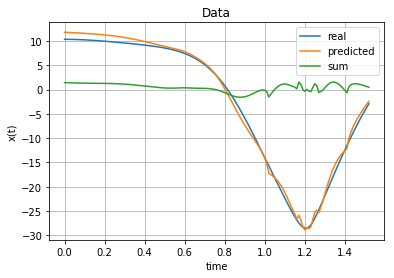

In [8]:
import random
import numpy as np
import operator
import math
import pandas as pd
import time
import os
import dill
from sympy import *
from sympy.parsing import sympy_parser

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp
from scoop import futures
from pandas import DataFrame

from concurrent.futures import ProcessPoolExecutor
import matplotlib.pyplot as plt
import multiprocessing as mp


def plot_pred(hof):
    func = toolbox.compile(expr=hof[0])
    y_r = {'t' : [], 'real' : []}
    y_hat = {'t' : [], 'pred' : []}
    y_sum = {'t' : [], 'sum' : []}
    for t,v1,v2,c1,c2,c3,c4,c5,c6 in pts:
        y_hat['t'].append(t)
        y_hat['pred'].append(func(v1,v2,c1,c2,c3,c4,c5,c6))
        y_r['t'].append(t)
        y_r['real'].append(f[t])
        y_sum['t'].append(t)
        y_sum['sum'].append(func(v1,v2,c1,c2,c3,c4,c5,c6)-f[t])
        
    from matplotlib import pyplot as plt
    plt.plot(y_r['t'], y_r['real'])
    plt.plot(y_hat['t'], y_hat['pred'])
    plt.plot(y_sum['t'], y_sum['sum'])

    plt.xlabel('time')  # x-axis
    plt.ylabel('x(t)')  # y-axis
    plt.title('Data')  # title
    plt.grid()  # grid
    plt.legend(['real','predicted','sum'])
    plt.show()  # plot show

###################### Define functions############################
def safeDiv(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1
    
def sqrt(left):
    if left>=0:
        return left**0.5
    else:
        return 0
    
def expe(left):
    if left>=0:
        return np.exp(-left)
    else:
        return 0


pset = gp.PrimitiveSet("MAIN", 8)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(expe, 1)
# pset.addPrimitive(safeDiv, 2)
pset.addPrimitive(sqrt,1)
# pset.addPrimitive(operator.neg, 1)
pset.addPrimitive(math.cos, 1)
pset.addPrimitive(math.sin, 1)

pset.renameArguments(ARG0='v1')
pset.renameArguments(ARG1='v2')
pset.renameArguments(ARG2='c1')
pset.renameArguments(ARG3='c2')
pset.renameArguments(ARG4='c3')
pset.renameArguments(ARG5='c4')
pset.renameArguments(ARG6='c5')
pset.renameArguments(ARG7='c6')

###################################################################
pool = mp.Pool(30)

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=3)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)
#toolbox.register("map", futures.map)

#########################input DATA#################################

def evalSymbReg(individual, points):
    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual)

    # Evaluate the mean squared error between the expression
    sqerrors = ((func(v1,v2,c1,c2,c3,c4,c5,c6) - f[t])**2 for t,v1,v2,c1,c2,c3,c4,c5,c6 in points)

    try:
        return max(sqerrors),
    except IndexError:
        return max(sqerrors),
    
toolbox.register("map", pool.map)

g = pd.read_csv('dp_pos.csv')
x1 = g['x1']
y1 = g['y1']
x2 = g['x2']
y2 = g['y2']
t = g['t']

g = pd.read_csv('dp_vel.csv')
vx1 = g['vx1']
vy1 = g['vy1']
vx2 = g['vx2']
vy2 = g['vy2']

f = {}
for i in range(len(t)):
    f[t[i]] = 9.8*(y1[i]+y2[i])


    
pts=[]

for i in range(len(t)):
    pts.append((t[i],np.sqrt(vx1[i]**2+vy1[i]**2),np.sqrt(vx2[i]**2+vy2[i]**2),1,2,3,4,5,0.5))
      
toolbox.register("evaluate", evalSymbReg, points=pts)
toolbox.register("select", tools.selTournament, tournsize=10)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=1, max_=3)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=5))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=5))

def main():
    pop = toolbox.population(n=20000)
    hof = tools.HallOfFame(1)
    
    stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
    stats_size = tools.Statistics(len)
    mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
    
    mstats.register("min", np.min)
    mstats.register("max", np.max)
    
    
    #############################################C.O, Muta,Gener##########
    try:
        pop, log = algorithms.eaSimple(pop, toolbox, 0.8, 0.8, 1000, stats=mstats,
                                       halloffame=hof, verbose=True)
        print (hof[0])
        plot_pred(hof)
        return hof
    
    except MemoryError:
        print (hof[0])
        plot_pred(hof)
        return hof
    
    
    except KeyboardInterrupt:
        print (hof[0])
        plot_pred(hof)
        return hof



if __name__ == "__main__":    
    hof = main()


In [7]:
from sympy import *
from sympy.parsing import sympy_parser


y1 = Symbol('y1')
y2 = Symbol('y2')


def add(a,b):
    return a+b

def expe(a):
    return exp(-a)

def mul(a,b):
    return a*b

def neg(a):
    return -a

def sub(a,b):
    return a-b

def sqrt(a):
    return a**0.5

def safeDiv(a,b):
    if b==0:
        return 1
    else:
        return a/b

expr_dict = {'add':add, 'expe':expe, 'sub':sub, 'mul':mul,'neg':neg,'sqrt':sqrt, 'safeDiv': safeDiv,'G':9.8,  'c1':1, 'c2':2, 'c3':3, 'c4':4,'c5':5, 'c6':0.5}

d = sympy_parser.parse_expr(str(hof[0]), local_dict=expr_dict)
d

-0.5*v1**2 - v2 + 0.545239211892605*(-v2 + 5.5)*(v2 + 3) - cos(exp(-v2)) - sin(3) + 2

/home/ban94gy/ban/local/lib/python3.5/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/ban94gy/ban/local/lib/python3.5/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


   	      	    fitness    	    size   
   	      	---------------	-----------
gen	nevals	max   	min    	max	min
0  	20000 	477451	64.5046	15 	2  
1  	19201 	1.66212e+06	50.685 	25 	2  
2  	19220 	98200.5    	44.0856	32 	2  
3  	19199 	602047     	34.6045	45 	2  
4  	19222 	4.16765e+06	23.8031	48 	2  
5  	19192 	290412     	16.5596	55 	2  
6  	19227 	216235     	11.7509	61 	2  
7  	19182 	423269     	7.09885	62 	2  
8  	19153 	200467     	2.23343	72 	2  
9  	19212 	390137     	2.23377	74 	2  
10 	19155 	87562.7    	1.93557	82 	2  
11 	19205 	104117     	1.47553	82 	2  
12 	19207 	64137.4    	1.1717 	88 	2  
13 	19176 	1.79381e+08	1.16552	93 	2  
14 	19145 	228418     	0.491475	91 	2  
15 	19153 	131762     	0.491475	92 	2  
16 	19181 	1.76243e+06	0.40609 	95 	2  
17 	19192 	543489     	0.344167	106	2  
18 	19223 	470547     	0.171686	102	2  
19 	19272 	5.44185e+06	0.171686	99 	2  
20 	19168 	1.7681e+06 	0.154489	96 	2  
21 	19266 	635958     	0.128525	105	2  
22 	19215 	519209     	0.11

196	19218 	70825.1    	0.00467934	109	2  
197	19218 	1.8124e+06 	0.00467934	111	2  
198	19180 	660383     	0.00467934	111	2  
199	19187 	224906     	0.00467934	112	2  
200	19185 	22424.2    	0.00467934	109	2  
201	19230 	660785     	0.00467934	112	2  
202	19169 	81417.2    	0.00467934	112	2  
203	19212 	317620     	0.00467934	111	2  
204	19197 	4.68786e+06	0.00467934	110	2  
205	19170 	1.70394e+07	0.00467934	109	2  
206	19240 	537001     	0.00467934	110	2  
207	19182 	221543     	0.00467934	110	2  
208	19186 	25108.2    	0.00467934	113	2  
209	19199 	1.77128e+06	0.00467934	110	2  
210	19264 	616783     	0.00467934	110	2  
211	19271 	1.2536e+07 	0.00467934	110	2  
212	19194 	235987     	0.00467934	109	2  
213	19215 	3.64742e+06	0.00467934	111	2  
214	19164 	424343     	0.00467934	113	2  
215	19179 	49912.8    	0.00467934	109	2  
216	19230 	387943     	0.00467934	111	2  
217	19276 	496737     	0.00467934	109	2  
218	19180 	3.2292e+06 	0.00467934	110	2  
219	19186 	45421.3    	0.00467934	

392	19172 	34420.1    	0.00257875	124	2  
393	19168 	1.74552e+06	0.00257875	129	2  
394	19181 	26631.8    	0.00257875	129	2  
395	19202 	79016.1    	0.00257875	129	2  
396	19154 	1.62217e+06	0.00257875	125	2  
397	19198 	221819     	0.00257875	128	2  
398	19214 	3.01116e+06	0.00257875	126	2  
399	19216 	93730.3    	0.00257875	130	2  
400	19224 	88093.5    	0.00257875	123	2  
401	19224 	235982     	0.00257875	128	2  
402	19182 	139820     	0.00257875	128	2  
403	19232 	103873     	0.00257875	128	2  
404	19205 	120821     	0.00257875	128	2  
405	19170 	1.61657e+07	0.00257875	124	2  
406	19166 	230766     	0.00257875	128	2  
407	19204 	104380     	0.00257875	129	2  
408	19206 	66230.4    	0.00257875	126	2  
409	19237 	66571.8    	0.00257875	128	2  
410	19179 	11362      	0.00257875	123	2  
411	19264 	1.92108e+06	0.00257875	128	2  
412	19217 	67207.5    	0.00257875	124	2  
413	19178 	285827     	0.00257875	123	2  
414	19182 	135282     	0.00257875	128	2  
415	19210 	77497.8    	0.00257875	

588	19205 	1.45746e+06	0.00257875	128	2  
589	19210 	162785     	0.00257875	125	2  
590	19165 	18133.9    	0.00257875	128	2  
591	19169 	37321.4    	0.00257875	123	2  
592	19239 	318695     	0.00257875	128	2  
593	19194 	264392     	0.00257875	129	2  
594	19151 	1.62122e+08	0.00257875	123	2  
595	19182 	27649.3    	0.00257875	128	2  
596	19157 	342995     	0.00257875	128	2  
597	19211 	1.67116e+06	0.00257875	128	2  
598	19192 	263937     	0.00257875	128	2  
599	19212 	2.2062e+06 	0.00257875	123	2  
600	19228 	1.77891e+06	0.00257875	128	2  
601	19214 	12792.4    	0.00257875	128	2  
602	19184 	24266.5    	0.00257875	128	2  
603	19198 	50655.9    	0.00257875	128	2  
604	19221 	420095     	0.00257875	128	2  
605	19197 	146350     	0.00257875	120	2  
606	19181 	265947     	0.00257875	128	2  
607	19175 	76147.2    	0.00257875	123	2  
608	19231 	149831     	0.00257875	128	2  
609	19199 	852577     	0.00257875	128	2  
610	19200 	549714     	0.00257875	127	2  
611	19154 	197176     	0.00257875	

784	19173 	69226.7    	0.00257875	122	2  
785	19194 	81171.2    	0.00257875	125	2  
786	19170 	58557.7    	0.00257875	129	2  
787	19203 	277613     	0.00257875	128	2  
788	19217 	392167     	0.00257875	123	2  
789	19226 	226598     	0.00257875	131	2  
790	19247 	52542.8    	0.00257875	128	2  
791	19159 	100823     	0.00257875	128	2  
792	19207 	1.80977e+06	0.00257875	123	2  
793	19193 	3.47018e+06	0.00257875	127	2  
794	19179 	917072     	0.00257875	128	2  
795	19189 	384279     	0.00257875	123	2  
796	19254 	21881.5    	0.00257875	123	2  
797	19225 	3.02998e+06	0.00257875	124	2  
798	19235 	189208     	0.00257875	128	2  
799	19215 	1.80684e+06	0.00257875	122	2  
800	19143 	103130     	0.00257875	123	2  
801	19167 	93436.1    	0.00257875	130	2  
802	19191 	103570     	0.00257875	122	2  
803	19202 	17132.4    	0.00257875	128	2  
804	19218 	60643.6    	0.00257875	128	2  
805	19185 	253944     	0.00257875	128	2  
806	19196 	63527.2    	0.00257875	128	2  
807	19212 	87771.3    	0.00257875	

980	19137 	56310.1    	0.0025726 	133	2  
981	19223 	173290     	0.0025726 	132	2  
982	19208 	3.64653e+06	0.0025726 	130	2  
983	19208 	36835.7    	0.0025726 	133	2  
984	19226 	52482.4    	0.0025726 	133	2  
985	19189 	4.44927e+06	0.0025726 	133	2  
986	19209 	1.3036e+08 	0.0025726 	133	2  
987	19195 	462786     	0.0025726 	133	2  
988	19229 	935368     	0.0025726 	133	2  
989	19178 	103873     	0.0025726 	138	2  
990	19223 	551728     	0.0025726 	131	2  
991	19170 	266780     	0.0025726 	137	2  
992	19229 	347952     	0.0025726 	133	2  
993	19222 	174795     	0.0025726 	133	2  
994	19178 	773544     	0.0025726 	133	2  
995	19208 	132219     	0.0025726 	130	2  
996	19177 	69189.2    	0.0025726 	141	2  
997	19192 	66823.2    	0.0025726 	133	2  
998	19216 	6460.81    	0.0025726 	133	2  
999	19220 	616217     	0.0025726 	133	2  
1000	19205 	150723     	0.0025726 	134	2  
add(add(add(add(add(add(cos(y2), cos(sqrt(y2))), cos(mul(sin(x2), expe(x1)))), cos(sin(mul(cos(y1), mul(x2, y2))))), 

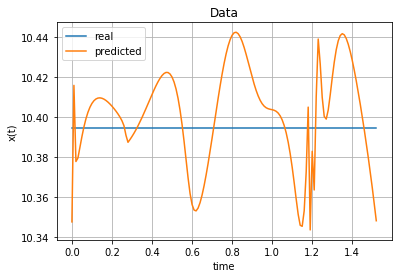

Process ForkPoolWorker-125:
Process ForkPoolWorker-144:
Process ForkPoolWorker-148:
Process ForkPoolWorker-128:
Process ForkPoolWorker-129:
Traceback (most recent call last):
Process ForkPoolWorker-141:
Process ForkPoolWorker-134:
Traceback (most recent call last):
Process ForkPoolWorker-149:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-121:
Process ForkPoolWorker-122:
Process ForkPoolWorker-138:
Process ForkPoolWorker-150:
Process ForkPoolWorker-137:
Process ForkPoolWorker-142:
Process ForkPoolWorker-143:
Process ForkPoolWorker-126:
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Process ForkPoolWorker-133:
Process ForkPoolWorker-132:
Process ForkPoolWorker-136:
Process ForkPoolWorker-130:
Process ForkPoolWorker-147:
Process ForkPoolWorker-135:
Process ForkPoolWorker-139:
Process ForkPoolWorker-124:
Process ForkPoolWorker-123:
Process ForkPoolWorker-131:
Pr

  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get

  File "/usr/lib/python3.5/multiprocessing/queues.py", line 343, in get
    res = self._reader.recv_bytes()
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
KeyboardInterrupt
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/usr/lib/python3.5/mult

In [4]:
import random
import numpy as np
import operator
import math
import pandas as pd
import time
import os
import dill
from sympy import *
from sympy.parsing import sympy_parser

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp
from scoop import futures
from pandas import DataFrame

from concurrent.futures import ProcessPoolExecutor
import matplotlib.pyplot as plt
import multiprocessing as mp


def plot_pred(hof):
    func = toolbox.compile(expr=hof[0])
    y_r = {'t' : [], 'real' : []}
    y_hat = {'t' : [], 'pred' : []}

    for t,v1,v2,x1,x2,y1,y2 in pts:
        y_hat['t'].append(t)
        y_hat['pred'].append(func(v1,v2,x1,x2,y1,y2))
        y_r['t'].append(t)
        y_r['real'].append(f[t])
        
    from matplotlib import pyplot as plt
    plt.plot(y_r['t'], y_r['real'])
    plt.plot(y_hat['t'], y_hat['pred'])

    plt.xlabel('time')  # x-axis
    plt.ylabel('x(t)')  # y-axis
    plt.title('Data')  # title
    plt.grid()  # grid
    plt.legend(['real','predicted'])
    plt.show()  # plot show

###################### Define functions############################
def safeDiv(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1
    
def sqrt(left):
    if left>=0:
        return left**0.5
    else:
        return 0
    
def expe(left):
    if left>=0:
        return np.exp(-left)
    else:
        return 0


pset = gp.PrimitiveSet("MAIN", 6)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(expe, 1)
# pset.addPrimitive(safeDiv, 2)
pset.addPrimitive(sqrt,1)
# pset.addPrimitive(operator.neg, 1)
pset.addPrimitive(math.cos, 1)
pset.addPrimitive(math.sin, 1)

pset.renameArguments(ARG0='v1')
pset.renameArguments(ARG1='v2')
pset.renameArguments(ARG2='x1')
pset.renameArguments(ARG3='x2')
pset.renameArguments(ARG4='y1')
pset.renameArguments(ARG5='y2')


###################################################################
pool = mp.Pool(30)

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=3)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)
#toolbox.register("map", futures.map)

#########################input DATA#################################

def evalSymbReg(individual, points):
    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual)

    # Evaluate the mean squared error between the expression
    sqerrors = ((func(v1,v2,x1,x2,y1,y2) - f[t])**2 for t,v1,v2,x1,x2,y1,y2 in points)

    try:
        return max(sqerrors),
    except IndexError:
        return max(sqerrors),
    
toolbox.register("map", pool.map)

g = pd.read_csv('dp_pos.csv')
x1 = g['x1']
y1 = g['y1']
x2 = g['x2']
y2 = g['y2']
t = g['t']

g = pd.read_csv('dp_vel.csv')
vx1 = g['vx1']
vy1 = g['vy1']
vx2 = g['vx2']
vy2 = g['vy2']

f = {}
for i in range(len(t)):
    f[t[i]] = 10.394469683442237


    
pts=[]

for i in range(len(t)):
    pts.append((t[i],np.sqrt(vx1[i]**2+vy1[i]**2),np.sqrt(vx2[i]**2+vy2[i]**2),x1[i],x2[i],y1[i],y2[i]))
      
toolbox.register("evaluate", evalSymbReg, points=pts)
toolbox.register("select", tools.selTournament, tournsize=10)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=1, max_=3)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=8))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=8))

def main():
    pop = toolbox.population(n=20000)
    hof = tools.HallOfFame(1)
    
    stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
    stats_size = tools.Statistics(len)
    mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
    
    mstats.register("min", np.min)
    mstats.register("max", np.max)
    
    
    #############################################C.O, Muta,Gener##########
    try:
        pop, log = algorithms.eaSimple(pop, toolbox, 0.8, 0.8, 1000, stats=mstats,
                                       halloffame=hof, verbose=True)
        print (hof[0])
        plot_pred(hof)
        return hof
    
    except MemoryError:
        print (hof[0])
        plot_pred(hof)
        return hof
    
    except KeyboardInterrupt:
        print (hof[0])
        plot_pred(hof)
        return hof



if __name__ == "__main__":    
    hof = main()


In [5]:
from sympy import *
from sympy.parsing import sympy_parser


y1 = Symbol('y1')
y2 = Symbol('y2')


def add(a,b):
    return a+b

def expe(a):
    return exp(-a)

def mul(a,b):
    return a*b

def neg(a):
    return -a

def sub(a,b):
    return a-b

def sqrt(a):
    return a**0.5

def safeDiv(a,b):
    if b==0:
        return 1
    else:
        return a/b

expr_dict = {'add':add, 'expe':expe, 'sub':sub, 'mul':mul,'neg':neg,'sqrt':sqrt, 'safeDiv': safeDiv,'G':9.8,  'c1':1, 'c2':2, 'c3':3, 'c4':4,'c5':5, 'c6':0.5}

d = sympy_parser.parse_expr(str(hof[0]), local_dict=expr_dict)
d

v1**0.5 + sin(cos(sin(x1 - x2 + y1) - exp(-exp(-exp(-v2))))) + cos(y2**0.5) + cos(y2) + cos((-x1 + x2 - sin(x2))*exp(-v2)**0.5) + cos((-x2 + y1 - y2)*sin(x1**2))**0.5 + cos(exp(-x1)*sin(x2)) + cos(sin(y2) - sin(x2 + y1)) + cos(x1 - x2 + sin(x2)) + cos(sin(x2*y2*cos(y1))) + cos(cos(y2)) + exp(-(v1**0.5 - y2**0.5)**0.5*(v1 - 2*x2 - y1*y2 + y2 + sin(x2)))